In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from pprint import pprint
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', -1)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_curve, auc, roc_auc_score

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if sys.path[0] == '':


In [4]:
df = pd.read_csv('../data/doc_train.csv')

In [16]:
df.columns

Index(['Unnamed: 0', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Summary',
       'Text', 'Date', 'year', 'words_count', 'unique_words',
       'new_token_words', 'data_lemmatized', 'clean_text', 'polarity',
       'subjectivity', 'doc2vec_vector_0', 'doc2vec_vector_1',
       'doc2vec_vector_2', 'doc2vec_vector_3', 'doc2vec_vector_4'],
      dtype='object')

In [4]:

df[df['new_token_words'].isnull()][['Summary','Text','clean_text','new_token_words']]

,Summary,Text,clean_text,new_token_words
100907,Poor Quality,"[[ASIN:I purchase these probably 1 year ago. I was very disappointed with the quality. I was unable to eat these sardines. They had scales and hard bones along with a tough texture. Sorry product. I'm giving them to the cats.<br /><br />B000EEWZF0 Crown Prince Natural Skinless & Boneless Sardines in Pure Olive Oil, 3.75-Ounce Cans (Pack of 12)]]",NaN,NaN
110463,&#1091;&#1076;&#1086;&#1073;&#1085;&#1072;&#1103; &#1091;&#1087;&#1072;&#1082;&#1086;&#1074;&#1082;&#1072;,"&#1056;&#1077;&#1096;&#1080;&#1083;&#1072; &#1079;&#1072;&#1082;&#1072;&#1079;&#1072;&#1090;&#1100; &#1101;&#1090;&#1080; &#1078;&#1077;&#1083;&#1072;&#1090;&#1080;&#1085;&#1082;&#1080;, &#1090;.&#1082;. &#1076;&#1086;&#1095;&#1082;&#1072; &#1087;&#1086;&#1096;&#1083;&#1072; &#1074; &#1096;&#1082;&#1086;&#1083;&#1091; &#1080; &#1090;&#1088;&#1077;&#1073;&#1091;&#1077;&#1090; &#1089;&#1083;&#1072;&#1076;&#1086;&#1089;&#1090;&#1080;. &#1054;&#1095;&#1077;&#1085;&#1100; &#1091;&#1076;&#1086;&#1073;&#1085;&#1072;&#1103; &#1091;&#1087;&#1072;&#1082;&#1086;&#1074;&#1082;&#1072;. &#1050;&#1072;&#1082; &#1088;&#1072;&#1079; &#1089;&#1090;&#1086;&#1083;&#1100;&#1082;&#1086; &#1082;&#1086;&#1085;&#1092;&#1077;&#1090;, &#1082;&#1072;&#1082; &#1080; &#1090;&#1088;&#1077;&#1073;&#1091;&#1077;&#1090;&#1089;&#1103;, &#1095;&#1090;&#1086;&#1073;&#1099; &#1089;&#1100;&#1077;&#1089;&#1090;&#1100; &#1080;&#1093; &#1079;&#1072; &#1087;&#1077;&#1088;&#1077;&#1084;&#1077;&#1085;&#1091;.",,NaN


In [32]:
df["new_token_words"].fillna("No data", inplace = True) 

Create a subset of dataset that only contains 0 or 1 label - 0 indicates bad review, while 1 is good review. 

In [33]:
def class_scores(score):
    if (score  == 1) | (score ==2):
        return 0
    else:
        return 1

def binary_data(df):
    scores = [1,2,5]
    mask = df['Score'].isin(scores)
    new_df = df[mask]
    new_df['Bi_Scores'] = new_df['Score'].apply(class_scores)
    return new_df

def make_string(text):
    return ' '.join([word for word in text])
    

In [5]:
bi_df = binary_data(df)

In [6]:
bi_df.shape

(196969, 25)

In [7]:
# max_df is 0.6 & min_df = 10
count_vect_1 = CountVectorizer(max_features= 5000)
doc_term_matrix_1 = count_vect_1.fit_transform(bi_df['new_token_words'].values)

In [8]:
features =count_vect_1.get_feature_names()
features_df = pd.DataFrame(doc_term_matrix_1.sum(axis =0).T,index = features, columns =['count'] )
features_df.sort_values(by ='count', ascending = False).iloc[:10]

,count
like,91094
tast,84943
love,70413
flavor,66925
one,63787
good,62090
product,61240
use,60030
great,58754
tri,57843


# Binary Classifier

# 1. Make balaced Dataset

In [9]:
# Separate majority and minority classes
df_majority = bi_df[bi_df['Bi_Scores']==1]
df_minority = bi_df[bi_df['Bi_Scores']==0]

In [17]:
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=39616,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['Bi_Scores'].value_counts()

1    39616
0    39616
Name: Bi_Scores, dtype: int64

# 2. New Features From Engineering 

I wanted to see how the new engineering features impacted on prediction of two labels
The features are:
'words_count', 'unique_words','polarity','subjectivity', 'doc2vec_vector_0', 'doc2vec_vector_1','doc2vec_vector_2', 'doc2vec_vector_3', 'doc2vec_vector_4'

In [18]:
def accuracy_score(matrix):
    row = matrix.shape[0]
    total = 0
    for i in range(row):
        total += matrix[i][i]
    return total/matrix.sum()

In [83]:
def near_score(matrix):
    q=np.diag(matrix, k=1).sum()
    w =np.diag(matrix, k=-1).sum()
    total = 0
    for i in range(matrix.shape[0]):
        total += matrix[i][i]
    return (total+q+w)/matrix.sum()


LogisticRegression() - 76%

In [22]:
interested_cols = [ 'words_count', 'unique_words','polarity',
       'subjectivity', 'doc2vec_vector_0', 'doc2vec_vector_1',
       'doc2vec_vector_2', 'doc2vec_vector_3', 'doc2vec_vector_4']


X_train, X_test, y_train, y_test = train_test_split(df_downsampled[interested_cols], df_downsampled['Bi_Scores'], test_size = 0.30, random_state = 42)
log = LogisticRegression()
log.fit(X_train.values, y_train.values)
y_log = log.predict(X_test.values)
cm_log = confusion_matrix(y_test.values, y_log)
accuracy_score(cm_log)

0.7612957509465713

RandomForestClassifier() - 78% - a little bit better than LogisticRegression

In [23]:
interested_cols = [ 'words_count', 'unique_words','polarity',
       'subjectivity', 'doc2vec_vector_0', 'doc2vec_vector_1',
       'doc2vec_vector_2', 'doc2vec_vector_3', 'doc2vec_vector_4']


X_train, X_test, y_train, y_test = train_test_split(df_downsampled[interested_cols], df_downsampled['Bi_Scores'], test_size = 0.30, random_state = 42)
rf = RandomForestClassifier()
rf.fit(X_train.values, y_train.values)
y_rf = rf.predict(X_test.values)
cm_rf = confusion_matrix(y_test.values, y_rf)
accuracy_score(cm_rf)

0.7776188472864956

GradientBoostingClassifier() - 77% - a little bit better than LogisticRegression but worse than RandomForest

In [24]:
interested_cols = [ 'words_count', 'unique_words','polarity',
       'subjectivity', 'doc2vec_vector_0', 'doc2vec_vector_1',
       'doc2vec_vector_2', 'doc2vec_vector_3', 'doc2vec_vector_4']


X_train, X_test, y_train, y_test = train_test_split(df_downsampled[interested_cols], df_downsampled['Bi_Scores'], test_size = 0.30, random_state = 42)
gb = GradientBoostingClassifier()
gb.fit(X_train.values, y_train.values)
y_gb = gb.predict(X_test.values)
cm_gb = confusion_matrix(y_test.values, y_gb)
accuracy_score(cm_gb)

0.7683634833824148

Select the RandomForest model and Include other features ('HelpfulnessNumerator', 'HelpfulnessDenominator')

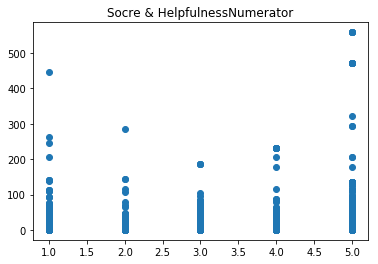

In [26]:
plt.scatter(df['Score'], df['HelpfulnessNumerator'])
plt.title("Socre & HelpfulnessNumerator");
plt.savefig('socre_HelpfulnessNumerator')

Including two features produces a better accuracy score with RandomForest 81%

In [27]:
interested_cols = [ 'words_count', 'unique_words','polarity',
       'subjectivity', 'doc2vec_vector_0', 'doc2vec_vector_1',
       'doc2vec_vector_2', 'doc2vec_vector_3', 'doc2vec_vector_4','HelpfulnessNumerator', 'HelpfulnessDenominator']


X_train, X_test, y_train, y_test = train_test_split(df_downsampled[interested_cols], df_downsampled['Bi_Scores'], test_size = 0.30, random_state = 42)
rf = RandomForestClassifier()
rf.fit(X_train.values, y_train.values)
y_rf_1 = rf.predict(X_test.values)
cm_rf_1 = confusion_matrix(y_test.values, y_rf_1)
accuracy_score(cm_rf_1)

0.8084981068573832

# 3. Word-Matrix created by either CounterVectorizer or TFID

CounterVectorizer & RandomForest 86%

In [49]:
interested_cols = ['new_token_words']

X = df_downsampled[interested_cols].values
y = df_downsampled['Bi_Scores'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

#vectorize and transform x
cv = CountVectorizer(max_features= 5000)
x_train_matrix = cv.fit_transform(X_train.ravel()).toarray()
x_test_matrix = cv.transform(X_test.ravel()).toarray()
    
rf = RandomForestClassifier() 
    
rf.fit(x_train_matrix, y_train)
y_hat = rf.predict(x_test_matrix)
    
rf_cm = confusion_matrix(y_test, y_hat)
accuracy_score(rf_cm)

0.8594867480016828

TfidfVectorize & RandomForest 86.2%

In [50]:
interested_cols = ['new_token_words']

X = df_downsampled[interested_cols].values
y = df_downsampled['Bi_Scores'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

#vectorize and transform x

tf = TfidfVectorizer(max_features= 5000)
x_train_matrix = tf.fit_transform(X_train.ravel()).toarray()
x_test_matrix = tf.transform(X_test.ravel()).toarray()
    
rf = RandomForestClassifier() 
    
rf.fit(x_train_matrix, y_train)
y_hat = rf.predict(x_test_matrix)
    
rf_cm_tf = confusion_matrix(y_test, y_hat)
accuracy_score(rf_cm_tf)

0.8628102650399664

TfidfVectorize (6000) & RandomForest -86.29% - not much improved

In [51]:
interested_cols = ['new_token_words']

X = df_downsampled[interested_cols].values
y = df_downsampled['Bi_Scores'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

#vectorize and transform x

tf = TfidfVectorizer(max_features= 6000)
x_train_matrix = tf.fit_transform(X_train.ravel()).toarray()
x_test_matrix = tf.transform(X_test.ravel()).toarray()
    
rf = RandomForestClassifier() 
    
rf.fit(x_train_matrix, y_train)
y_hat = rf.predict(x_test_matrix)
    
rf_cm_tf = confusion_matrix(y_test, y_hat)
accuracy_score(rf_cm_tf)

0.8629785443836769

# Combine Feature 1 & Word-TFID Vectorizer 

In [59]:
ignore_cols = ['Unnamed: 0', 'Id', 'ProductId', 'UserId', 'ProfileName',
     'Summary','Text', 'Date', 'year', 'data_lemmatized', 'clean_text', 'Score']

bi_df = df_downsampled.drop(columns = ignore_cols)
bi_df.head(1)

,HelpfulnessNumerator,HelpfulnessDenominator,words_count,unique_words,new_token_words,polarity,subjectivity,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4,Bi_Scores
80196,0,0,58,25,bought pregnant want low sodium snack love lil crunchi veggi dip flavor best mild addict son month old readi tri ill buy enough us,0.218519,0.488889,-0.013772,-0.081063,0.023822,0.063172,0.010859,1


In [61]:
x= bi_df
y= bi_df.Bi_Scores

features_1 = ['words_count','unique_words','polarity','subjectivity','doc2vec_vector_0','doc2vec_vector_1','doc2vec_vector_2','doc2vec_vector_3','doc2vec_vector_4',
             'HelpfulnessNumerator', 'HelpfulnessDenominator']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)

tfidf_multi = TfidfVectorizer(max_features= 6000)

#vectorize train words and then transform them & combine the matrix with the new features to create the train's final matrix
x_words_train = tfidf_multi.fit_transform(x_train["new_token_words"].values.ravel()).toarray()
x_train_matrix = np.concatenate((x_words_train, x_train[features_1].values), axis =1)

# transform test words from tfidf fitted by the train words & combine test matrix with test new features
x_words_test = tfidf_multi.transform(x_test["new_token_words"].values.ravel()).toarray()
x_test_matrix = np.concatenate((x_words_test, x_test[features_1].values), axis =1) 

rf=RandomForestClassifier(n_estimators = 100, random_state = 42)

rf.fit(x_train_matrix, y_train.values)
y_hat = rf.predict(x_test_matrix)
test=pd.concat([y_test, pd.Series(y_hat, index = y_test.index)], axis = 1)
cm_comb= confusion_matrix(y_test, y_hat)
accuracy_score(cm_comb)

0.9003596895311415

Tunning the model (n_estimator = 250, max_features = 'auto')

In [62]:
x= bi_df
y= bi_df.Bi_Scores

features_1 = ['words_count','unique_words','polarity','subjectivity','doc2vec_vector_0','doc2vec_vector_1','doc2vec_vector_2','doc2vec_vector_3','doc2vec_vector_4',
             'HelpfulnessNumerator', 'HelpfulnessDenominator']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 42)

tfidf_multi = TfidfVectorizer(max_features= 6000)

#vectorize train words and then transform them & combine the matrix with the new features to create the train's final matrix
x_words_train = tfidf_multi.fit_transform(x_train["new_token_words"].values.ravel()).toarray()
x_train_matrix = np.concatenate((x_words_train, x_train[features_1].values), axis =1)

# transform test words from tfidf fitted by the train words & combine test matrix with test new features
x_words_test = tfidf_multi.transform(x_test["new_token_words"].values.ravel()).toarray()
x_test_matrix = np.concatenate((x_words_test, x_test[features_1].values), axis =1) 

rf=RandomForestClassifier(n_estimators = 250, random_state = 42, max_features='auto')

rf.fit(x_train_matrix, y_train.values)
y_hat = rf.predict(x_test_matrix)
test=pd.concat([y_test, pd.Series(y_hat, index = y_test.index)], axis = 1)
cm_comb= confusion_matrix(y_test, y_hat)
accuracy_score(cm_comb)

0.9023789991796555

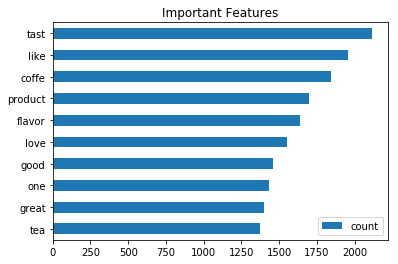

In [66]:
features_bi_df=pd.DataFrame(x_words_train.sum(axis = 0).T, index = tfidf_multi.get_feature_names(), columns =['count'])
features_bi_df.sort_values(by='count', ascending = False)[:10][::-1].plot.barh()
plt.title("Important Features")
plt.savefig('important_features_binary.png')

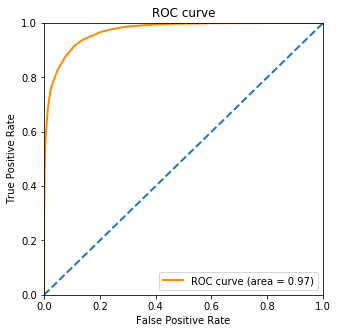

In [69]:
y_pred = [x[1] for x in rf.predict_proba(x_test_matrix)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (5, 5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.title("ROC curve")
plt.savefig("ROC_curve")
plt.show();

In [15]:
ignore_cols = ["new_token_words","Bi_Scores"]
features = [c for c in mix_bi_df.columns if c not in ignore_cols]

X_train, X_test, y_train, y_test = train_test_split(mix_bi_df[features], mix_bi_df['Bi_Scores'], test_size = 0.20, random_state = 42)
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf.fit(X_train.values, y_train.values)
y_hat_mix = rf.predict(X_test.values)
rf_cm_mix = confusion_matrix(y_test, y_hat_mix)

In [56]:
tn, fp, fn, tp = rf_cm_mix.ravel()
accuracy_tf_mix = (tn + tp) /(tn+fp+fn+tp)
accuracy_tf_mix

0.9303701071229121

rf = RandomForestClassifier(random_state = 42)
param_grid = {
    'n_estimators': [50,150,200,250],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [2,3,5]
}
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5)
CV_rf.fit(X_train.values, y_train.values)
print (CV_rf.best_params_)

# Multiple Classifier 

In [76]:
df['Score'].value_counts()

5    157353
4    36255 
1    25399 
3    20146 
2    14217 
Name: Score, dtype: int64

In [78]:
ignore_cols = ['Unnamed: 0', 'Id', 'ProductId', 'UserId', 'ProfileName',
        'Summary','Text', 'Date', 'year', 'data_lemmatized', 'clean_text']
df.drop(columns = ignore_cols, inplace = True)
df.columns

Index(['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score',
       'words_count', 'unique_words', 'new_token_words', 'polarity',
       'subjectivity', 'doc2vec_vector_0', 'doc2vec_vector_1',
       'doc2vec_vector_2', 'doc2vec_vector_3', 'doc2vec_vector_4'],
      dtype='object')

In [79]:
df_5 = df[df['Score'] == 5]
df_4 = df[df['Score'] == 4]
df_3 = df[df['Score'] == 3]
df_2 = df[df['Score'] == 2]
df_1 = df[df['Score'] == 1]

In [80]:
df_5_downsampled = resample(df_5, replace=False,    # sample without replacement
                            n_samples=14217,     # to match minority class
                            random_state=123)
df_4_downsampled = resample(df_4, replace=False,    # sample without replacement
                            n_samples=14217,     # to match minority class
                            random_state=123)
df_3_downsampled = resample(df_3, replace=False,    # sample without replacement
                            n_samples=14217,     # to match minority class
                            random_state=123)
df_1_downsampled = resample(df_1, replace=False,    # sample without replacement
                            n_samples=14217,     # to match minority class
                            random_state=123)

In [81]:
# Combine minority class with downsampled majority class
df_downsampled_mulit = pd.concat([df_5_downsampled, df_4_downsampled, df_3_downsampled,df_1_downsampled,df_2])
# Display new class counts
df_downsampled_mulit['Score'].value_counts()

5    14217
4    14217
3    14217
2    14217
1    14217
Name: Score, dtype: int64

# New Features From Engineering - 50.1%

In [100]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator','words_count', 'unique_words', 'polarity',
       'subjectivity', 'doc2vec_vector_0', 'doc2vec_vector_1',
       'doc2vec_vector_2', 'doc2vec_vector_3', 'doc2vec_vector_4']

X_train, X_test, y_train, y_test = train_test_split(df_downsampled_mulit[features], df_downsampled_mulit['Score'], test_size = 0.20, random_state = 42)
rf_mix = RandomForestClassifier(n_estimators = 250, random_state = 42, max_features ='auto')
rf_mix.fit(X_train.values, y_train.values)
y_hat_mix = rf_mix.predict(X_test.values)
test=pd.concat([y_test, pd.Series(y_hat_mix, index = y_test.index)], axis = 1)
cm_multi = confusion_matrix(y_test, y_hat_mix)
print(f'accuracy score: {accuracy_score(cm_multi)}, near prediction:{near_score(cm_multi)}')
cm_multi

accuracy score: 0.5059435886614616, near prediction:0.7853977632411901


array([[1930,  354,  194,  128,  184],
       [ 679, 1311,  332,  263,  251],
       [ 419,  384, 1223,  398,  463],
       [ 205,  259,  374, 1160,  865],
       [ 198,  191,  296,  587, 1569]], dtype=int64)

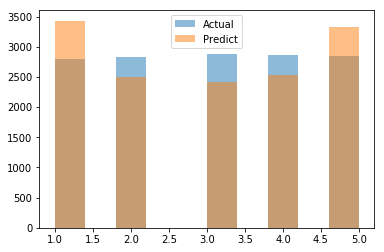

In [101]:
plt.hist(test['Score'], label = 'Actual', alpha = 0.5)
plt.hist(test[0], alpha = 0.5, label = 'Predict')
plt.legend();
plt.savefig('newe_features_Matrix.png')

# Word-Matrix - 60%

In [85]:
X_train, X_test, y_train, y_test = train_test_split(df_downsampled_mulit['new_token_words'],df_downsampled_mulit['Score'], test_size = 0.20, random_state = 42)

tf = TfidfVectorizer(max_features= 6000)
x_train_matrix = tf.fit_transform(X_train.values.ravel()).toarray()
x_test_matrix = tf.transform(X_test.values.ravel()).toarray()
rclf = RandomForestClassifier(n_estimators = 250, random_state = 42, max_features ='auto')
rclf.fit(x_train_matrix, y_train)
y_hat_words = rclf.predict(x_test_matrix)
test=pd.concat([y_test, pd.Series(y_hat_words, index = y_test.index)], axis = 1)
cm_word = confusion_matrix(y_test, y_hat_words)
print(f'accuracy score: {accuracy_score(cm_word)}, near prediction:{near_score(cm_word)}')
cm_multi

accuracy score: 0.6024477737919393, near prediction:0.8473658296405712


array([[1930,  354,  194,  128,  184],
       [ 679, 1311,  332,  263,  251],
       [ 419,  384, 1223,  398,  463],
       [ 205,  259,  374, 1160,  865],
       [ 198,  191,  296,  587, 1569]], dtype=int64)

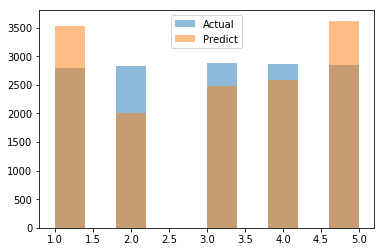

In [93]:
plt.hist(test['Score'], label = 'Actual', alpha = 0.5)
plt.hist(test[0], alpha = 0.5, label = 'Predict')
plt.legend();
plt.savefig('Word_Matrix.png')

# New Features & Word-Matrix 60.5%

In [95]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator','words_count', 'unique_words', 'polarity',
       'subjectivity', 'doc2vec_vector_0', 'doc2vec_vector_1',
       'doc2vec_vector_2', 'doc2vec_vector_3', 'doc2vec_vector_4']


x_train, x_test, y_train, y_test = train_test_split(df_downsampled_mulit, df_downsampled_mulit['Score'], test_size = 0.20, random_state = 42)

tfidf_multi = TfidfVectorizer(max_features= 6000)

#vectorize train words and then transform them & combine the matrix with the new features to create the train's final matrix
x_words_train = tfidf_multi.fit_transform(x_train["new_token_words"].values.ravel()).toarray()
x_train_matrix = np.concatenate((x_words_train, x_train[features].values), axis =1)

# transform test words from tfidf fitted by the train words & combine test matrix with test new features
x_words_test = tfidf_multi.transform(x_test["new_token_words"].values.ravel()).toarray()
x_test_matrix = np.concatenate((x_words_test, x_test[features].values), axis =1)

rf=RandomForestClassifier(n_estimators = 250, random_state = 42, max_features ='auto')

rf.fit(x_train_matrix, y_train.values)
y_hat = rf.predict(x_test_matrix)
test=pd.concat([y_test, pd.Series(y_hat, index = y_test.index)], axis = 1)
cm_mulit_com= confusion_matrix(y_test, y_hat)
print(f'accuracy score: {accuracy_score(cm_mulit_com)}, near prediction:{near_score(cm_mulit_com)}')
cm_mulit_com

accuracy score: 0.6056833368502497, near prediction:0.8539776324119013


array([[2241,  200,  120,   71,  158],
       [ 712, 1365,  354,  187,  218],
       [ 370,  285, 1481,  445,  306],
       [ 150,  118,  361, 1455,  779],
       [ 184,   76,  118,  394, 2069]], dtype=int64)

Exclude Subjectivity !

In [102]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator','words_count', 'unique_words', 'polarity',
       'subjectivity', 'doc2vec_vector_0', 'doc2vec_vector_1',
       'doc2vec_vector_2', 'doc2vec_vector_3', 'doc2vec_vector_4']


x_train, x_test, y_train, y_test = train_test_split(df_downsampled_mulit, df_downsampled_mulit['Score'], test_size = 0.20, random_state = 42)

tfidf_multi = TfidfVectorizer(max_features= 8000)

#vectorize train words and then transform them & combine the matrix with the new features to create the train's final matrix
x_words_train = tfidf_multi.fit_transform(x_train["new_token_words"].values.ravel()).toarray()
x_train_matrix = np.concatenate((x_words_train, x_train[features].values), axis =1)

# transform test words from tfidf fitted by the train words & combine test matrix with test new features
x_words_test = tfidf_multi.transform(x_test["new_token_words"].values.ravel()).toarray()
x_test_matrix = np.concatenate((x_words_test, x_test[features].values), axis =1)

rf=RandomForestClassifier(n_estimators = 250, random_state = 42, max_features ='auto')

rf.fit(x_train_matrix, y_train.values)
y_hat = rf.predict(x_test_matrix)
test=pd.concat([y_test, pd.Series(y_hat, index = y_test.index)], axis = 1)
cm_mulit_com= confusion_matrix(y_test, y_hat)
print(f'accuracy score: {accuracy_score(cm_mulit_com)}, near prediction:{near_score(cm_mulit_com)}')
cm_mulit_com

accuracy score: 0.6061053668143771, near prediction:0.855665752268411


array([[2240,  214,  118,   71,  147],
       [ 725, 1353,  351,  195,  212],
       [ 386,  264, 1488,  457,  292],
       [ 163,  107,  349, 1450,  794],
       [ 173,   75,  113,  394, 2086]], dtype=int64)

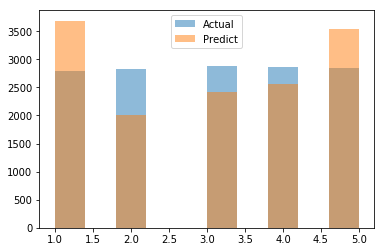

In [99]:
plt.hist(test['Score'], label = 'Actual', alpha = 0.5)
plt.hist(test[0], alpha = 0.5, label = 'Predict')
plt.legend();
plt.savefig('New_Features_Word_Matrix_8000.png')

In [104]:
features_mulit=pd.DataFrame(x_words_test.sum(axis = 0).T, index = tfidf_multi.get_feature_names(), columns =['count'])

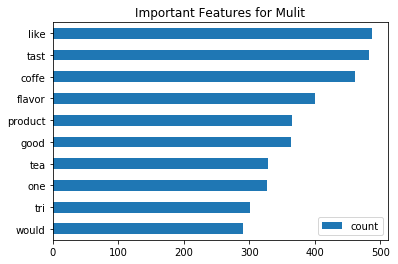

In [105]:
features_mulit.sort_values(by='count', ascending = False)[:10][::-1].plot.barh()
plt.title("Important Features for Mulit")
plt.savefig('important_features_2.png')

In [ ]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator','words_count', 'unique_words', 'polarity',
       'subjectivity', 'doc2vec_vector_0', 'doc2vec_vector_1',
       'doc2vec_vector_2', 'doc2vec_vector_3', 'doc2vec_vector_4']


x_train, x_test, y_train, y_test = train_test_split(df_downsampled_mulit, df_downsampled_mulit['Score'], test_size = 0.20, random_state = 42)

tfidf = TfidfVectorizer(max_features= 6000)
tfidf_result = tfidf.fit_transform(x_train["new_token_words"].values.ravel()).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = x_train.index
mix_mulit_df = pd.concat([x_train, tfidf_df], axis=1)

tfidf_1 = TfidfVectorizer(max_features= 6000)
x_train_matrix = tfidf_1.fit(mix_mulit_df.values.ravel()).toarray()

In [ ]:
x_words_test = tfidf.transform(x_test["new_token_words"].values.ravel()).toarray()
x_test_matrix = np.concatenate((x_words_test, x_test[features].values), axis =1)

rf=RandomForestClassifier(n_estimators = 250, random_state = 42, max_features ='auto')

rf.fit(mix_mulit_df, y_train.values)
y_hat = rf.predict(x_test_matrix)
test=pd.concat([y_test, pd.Series(y_hat, index = y_test.index)], axis = 1)
cm_mulit_com= confusion_matrix(y_test, y_hat)
print(f'accuracy score: {accuracy_score(cm_mulit_com)}, near prediction:{near_score(cm_mulit_com)}')
cm_mulit_com

# RandomForest Regressor

In [28]:
re=RandomForestRegressor(n_estimators = 100, random_state = 42)

re.fit(x_train_matrix, y_train.values)
y_hat_re = re.predict(x_test_matrix)
test_re=pd.concat([y_test, pd.Series(y_hat_re, index = y_test.index)], axis = 1)


In [35]:
test_re.rename(columns = {0:'y_hat_cont'}, inplace = True) 

In [37]:
test_re

,Score,y_hat_cont
176243,3,2.60
210483,1,1.17
43123,5,4.65
223829,1,1.42
145606,2,2.13
...,...,...
110087,4,3.63
14646,5,3.48
225174,1,1.12
109519,3,2.85


In [38]:
test_re['y_hat_cont'].max()

4.99

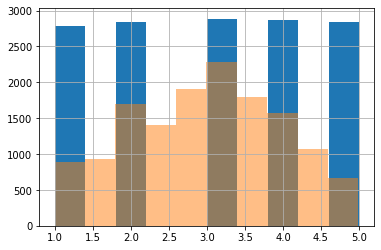

In [44]:
test_re['Score'].hist()
test_re['y_hat_cont'].hist(alpha = 0.5);

In [65]:
def re_score(score):
    if score < 2:
        return 1
    elif score <=2.5:
        return 2
    elif score <=3.5:
        return 3
    elif score <= 4:
        return 4
    else:
        return 5

In [66]:
test_re['y_round'] = test_re['y_hat_cont'].round(0).astype(int)

In [67]:
test_re['y_1'] = test_re['y_hat_cont'].apply(re_score)

In [48]:
test_re

,Score,y_hat_cont,y_round_up
176243,3,2.60,3
210483,1,1.17,1
43123,5,4.65,5
223829,1,1.42,1
145606,2,2.13,2
...,...,...,...
110087,4,3.63,4
14646,5,3.48,3
225174,1,1.12,1
109519,3,2.85,3


In [49]:
cm_re= confusion_matrix(test_re['Score'].values, test_re['y_round_up'].values)